In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
mnist = input_data.read_data_sets("MNIST_data/")
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
class AutoEncoder(object):
    def __init__(self, m, n, eta = 0.01):
        """
        m: Number of neurons in input/output layer
        n: number of neurons in hidden layer
        """
        self._m = m
        self._n = n
        self.learning_rate = eta
       
        # Create the Computational graph
       
        # Weights and biases
        self._W1 = tf.Variable(tf.random_normal(shape=(self._m,self._n)))
        self._W2 = tf.Variable(tf.random_normal(shape=(self._n,self._m)))
        self._b1 = tf.Variable(np.zeros(self._n).astype(np.float32))  #bias for hidden layer
        self._b2 = tf.Variable(np.zeros(self._m).astype(np.float32))  #bias for output layer
            
        # Placeholder for inputs
        self._X = tf.placeholder('float', [None, self._m])
        
        self.y = self.encoder(self._X)
        self.r = self.decoder(self.y)
        error = self._X - self.r
        
        self._loss = tf.reduce_mean(tf.pow(error, 2))
        self._opt = tf.train.AdamOptimizer(self.learning_rate).minimize(self._loss)
        
                                               
    def encoder(self, x):
        h = tf.matmul(x, self._W1) + self._b1
        return tf.nn.sigmoid(h)
            
        
    def decoder(self, x):
        h = tf.matmul(x, self._W2) + self._b2
        return tf.nn.sigmoid(h)
            
    def set_session(self, session):
        self.session = session
            
    
    def reduced_dimension(self, x):
        h = self.encoder(x)
        return self.session.run(h, feed_dict={self._X: x})
    
    def reconstruct(self,x):
        h = self.encoder(x)
        r = self.decoder(h)
        return self.session.run(r, feed_dict={self._X: x})
    
    def getWeights(self):
        return self.session.run([self._W1, self._W2,self._b1, self._b2])
        
        
        
    def fit(self, X, epochs = 1, batch_size = 100):
        N, D = X.shape
        num_batches = N // batch_size
        
        obj = []
        for i in range(epochs):
            #X = shuffle(X)
            for j in range(num_batches):
                batch = X[j * batch_size: (j * batch_size + batch_size)]
                _, ob = self.session.run([self._opt,self._loss], feed_dict={self._X: batch})
                if j % 100 == 0:
                    print('training epoch {0} batch {2} cost {1}'.format(i,ob, j)) 
                obj.append(ob)
        return obj

In [4]:
n_hidden = 256
Xtrain = trX.astype(np.float32)
Xtest = teX.astype(np.float32)
_, m = Xtrain.shape

autoEncoder = AutoEncoder(m, n_hidden)

#Initialize all variables
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    autoEncoder.set_session(sess)
    err = autoEncoder.fit(Xtrain, epochs=10)
    out = autoEncoder.reconstruct(Xtest[0:100])
    W1, W2, b1, b2 = autoEncoder.getWeights()

training epoch 0 batch 0 cost 0.43974411487579346
training epoch 0 batch 100 cost 0.06616750359535217
training epoch 0 batch 200 cost 0.055376362055540085
training epoch 0 batch 300 cost 0.050792209804058075
training epoch 0 batch 400 cost 0.044158853590488434
training epoch 0 batch 500 cost 0.04376433044672012
training epoch 1 batch 0 cost 0.04134460911154747
training epoch 1 batch 100 cost 0.03601594269275665
training epoch 1 batch 200 cost 0.03590889275074005
training epoch 1 batch 300 cost 0.037348467856645584
training epoch 1 batch 400 cost 0.03380809724330902
training epoch 1 batch 500 cost 0.03696693107485771
training epoch 2 batch 0 cost 0.035466767847537994
training epoch 2 batch 100 cost 0.030675584450364113
training epoch 2 batch 200 cost 0.031160620972514153
training epoch 2 batch 300 cost 0.03341842442750931
training epoch 2 batch 400 cost 0.03065233863890171
training epoch 2 batch 500 cost 0.03380682319402695
training epoch 3 batch 0 cost 0.0325271412730217
training epoch

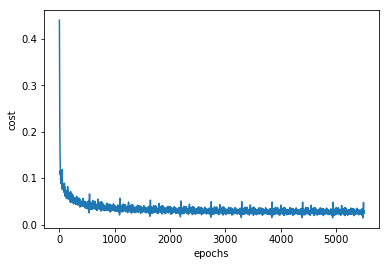

In [5]:
plt.plot(err)
plt.xlabel('epochs')
plt.ylabel('cost')

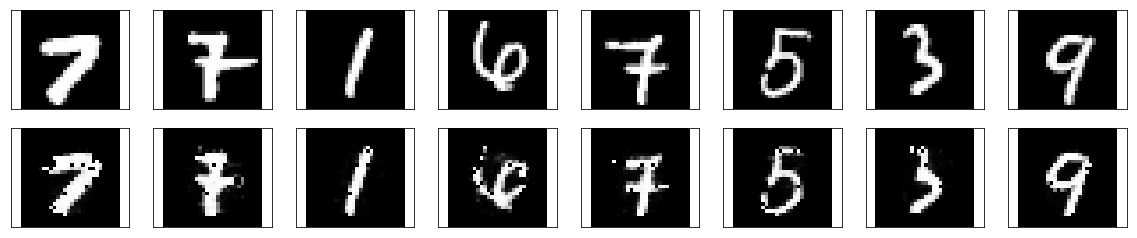

In [6]:
# Plotting original and reconstructed images
row, col = 2, 8
idx = np.random.randint(0, 100, row * col // 2)
f, axarr = plt.subplots(row, col, sharex=True, sharey=True, figsize=(20,4))
for fig, row in zip([Xtest,out], axarr):
    for i,ax in zip(idx,row):
        ax.imshow(fig[i].reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


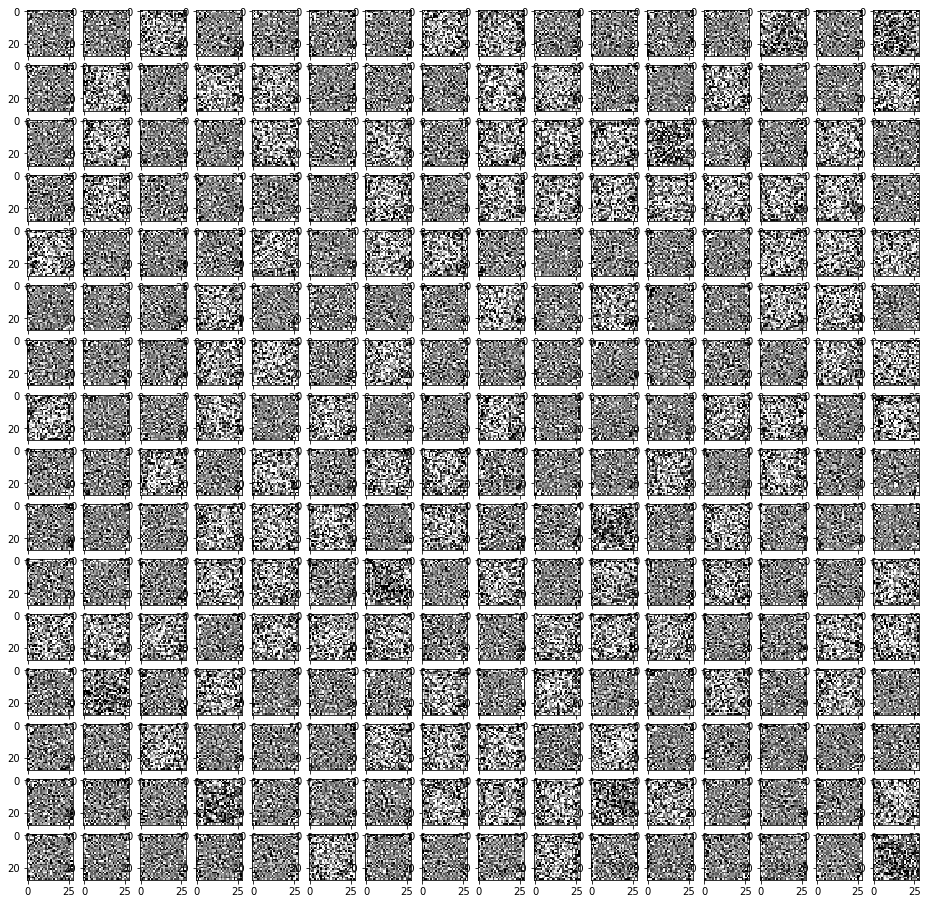

In [7]:
dim = math.ceil(math.sqrt(n_hidden))
plt.figure(1, figsize=(dim, dim))
for i in range(0, n_hidden):
    im = W1.flatten()[i::n_hidden].reshape((28, 28))
    plt.subplot(dim, dim, i + 1)
    # plt.title('Feature Weights ' + str(i))
    plt.imshow(im, cmap="gray", clim=(-1.0, 1.0))